In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
sns.set()

os.chdir('../..')

DATA = Path('data')
RAW  = DATA/'raw'
PROCESSED = DATA/'processed'
SUBMISSIONS = DATA/'submissions'

In [2]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 400)

## Preprocessing

In [131]:
%%time
test_session = pd.read_csv('data/raw/random_submission.csv')
test_tracking = pd.read_csv('data/raw/test_tracking.csv')
all_session = pd.read_csv('data/raw/train_session.csv') 
all_tracking = pd.read_csv('data/raw/train_tracking.csv')
productid_category = pd.read_csv('data/raw/productid_category.csv')

In [139]:
from src.utils_k import add_type_features
from src.utils_j import generate_validation_set
from src.utils_f import duration_feature

In [135]:
trn_session, trn_tracking, val_session, val_tracking = generate_validation_set(
                                                            all_session, 
                                                            all_tracking, 
                                                            test_size=0.4)

In [138]:
%%time
proc_train = add_type_features(trn_session[['sid']], trn_tracking)
proc_val = add_type_features(val_session[['sid']], val_tracking)
proc_all = add_type_features(all_session[['sid']], all_tracking)
proc_test = add_type_features(test_session, test_tracking)

In [140]:
%%time
proc_train = duration_feature(proc_train, trn_tracking)
proc_val = duration_feature(proc_val, val_tracking)
proc_all = duration_feature(proc_all, all_tracking)
proc_test = duration_feature(proc_test, test_tracking)

/anaconda/envs/kaggle/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


CPU times: user 14.1 s, sys: 1.55 s, total: 15.6 s
Wall time: 15.6 s


In [148]:
wp_train = pd.read_feather(PROCESSED/'train_WP.feather')
wp_test = pd.read_feather(PROCESSED/'test_WP.feather')

/anaconda/envs/kaggle/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [152]:
proc_train = pd.merge(proc_train, wp_train, how='left', on='sid')
proc_val = pd.merge(proc_val, wp_train, how='left', on='sid')
proc_test = pd.merge(proc_test, wp_train, how='left', on='sid')

In [160]:
for df in [proc_train, proc_val, proc_test]:
    df['WATCHED_PRODUCT'] = df.WATCHED_PRODUCT.astype('category')

In [194]:
cont_cols = [x for x in proc_train if x!='WATCHED_PRODUCT' and x!='sid']
cat_cols = ['WATCHED_PRODUCT']

In [167]:
to_cat_codes(proc_train, cat_cols)
apply_cats(proc_test, proc_train)

In [173]:
for df in [proc_train, proc_val, proc_test]:
    df['WATCHED_PRODUCT'] = df.WATCHED_PRODUCT.cat.codes

In [183]:
for df in [proc_train, proc_val, proc_test]:
    df['WATCHED_PRODUCT'] = df.WATCHED_PRODUCT.astype(int)

In [191]:
X_train = proc_train.drop('sid', axis=1).reset_index(drop=True)
y_train = trn_session.target.reset_index(drop=True)

X_val = proc_val.drop('sid', axis=1).reset_index(drop=True)
y_val = val_session.target.reset_index(drop=True)

X_test = proc_test.drop('sid', axis=1).reset_index(drop=True)

temp_columns = X_train.columns
X_val = X_val[temp_columns]
X_test = X_test[temp_columns]

In [192]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train[cont_cols])
X_train_std = scaler.transform(X_train[cont_cols])
X_val_std = scaler.transform(X_val[cont_cols])

In [197]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 10).fit(X_train_std)

X_train_pca = (pca.transform(X_train_std))
X_val_pca = (pca.transform(X_val_std))

X_train = pd.concat([pd.DataFrame(X_train_std, columns=cont_cols), 
                     pd.DataFrame(X_train_pca, 
                                  columns=[f'PCA_{i+1:02}' \
                                for i in range(X_train_pca.shape[1])]),
                     pd.DataFrame(X_train[cat_cols])], axis=1)
X_val = pd.concat([pd.DataFrame(X_val_std, columns=cont_cols), 
                     pd.DataFrame(X_val_pca, 
                                  columns=[f'PCA_{i+1:02}' \
                                for i in range(X_val_pca.shape[1])]),
                     pd.DataFrame(X_val[cat_cols])], axis=1)

In [199]:
import lightgbm as lgbm

# parameters for LightGBMClassifier
params = {
    'objective' :'binary',
    'max_depth' : 7,
    'boosting_type' : 'dart',
    'xgboost_dart_mode': True,
    'learning_rate': 0.01,
    'metric': 'binary_logloss',
    'verbose': 1,
    'bagging_fraction': 0.5,
}

d_train = lgbm.Dataset(X_train, label=trn_session.target)
d_valid = lgbm.Dataset(X_val, label=val_session.target)

clf = lgbm.train(params, d_train, valid_sets=[d_valid],
                num_boost_round=100000, early_stopping_rounds=30, verbose_eval=100)

Training until validation scores don't improve for 30 rounds.
[100]	valid_0's binary_logloss: 0.2844
[200]	valid_0's binary_logloss: 0.278229
[300]	valid_0's binary_logloss: 0.275764
[400]	valid_0's binary_logloss: 0.274637
[500]	valid_0's binary_logloss: 0.274134
[600]	valid_0's binary_logloss: 0.273958
[700]	valid_0's binary_logloss: 0.273882
[800]	valid_0's binary_logloss: 0.273811
Early stopping, best iteration is:
[808]	valid_0's binary_logloss: 0.273807


In [147]:
import lightgbm as lgbm

# parameters for LightGBMClassifier
params = {
    'objective' :'binary',
    'max_depth' : 7,
    'boosting_type' : 'dart',
    'xgboost_dart_mode': True,
    'learning_rate': 0.01,
    'metric': 'binary_logloss',
    'verbose': 1,
    'bagging_fraction': 0.5,
}

d_train = lgbm.Dataset(X_train, label=trn_session.target)
d_valid = lgbm.Dataset(X_val, label=val_session.target)

clf = lgbm.train(params, d_train, valid_sets=[d_valid],
                num_boost_round=100000, early_stopping_rounds=30, verbose_eval=100)

Training until validation scores don't improve for 30 rounds.
[100]	valid_0's binary_logloss: 0.284392
[200]	valid_0's binary_logloss: 0.278208
[300]	valid_0's binary_logloss: 0.275771
[400]	valid_0's binary_logloss: 0.274652
[500]	valid_0's binary_logloss: 0.274146
[600]	valid_0's binary_logloss: 0.27395
[700]	valid_0's binary_logloss: 0.273848
[800]	valid_0's binary_logloss: 0.273799
Early stopping, best iteration is:
[815]	valid_0's binary_logloss: 0.273791


In [285]:
import lightgbm as lgbm

# parameters for LightGBMClassifier
params = {
    'objective' :'binary',
    'max_depth' : 7,
    'boosting_type' : 'dart',
    'xgboost_dart_mode': True,
    'learning_rate': 0.01,
    'metric': 'binary_logloss',
    'verbose': 1,
    'bagging_fraction': 0.5,
}

d_train = lgbm.Dataset(X_train[cont_cols], label=X_train[target_col])
d_valid = lgbm.Dataset(X_val[cont_cols], label=X_val[target_col])

clf = lgbm.train(params, d_train, valid_sets=[d_valid],
                num_boost_round=100000, early_stopping_rounds=30, verbose_eval=100)

Training until validation scores don't improve for 30 rounds.
[100]	valid_0's binary_logloss: 0.284443
[200]	valid_0's binary_logloss: 0.278236
[300]	valid_0's binary_logloss: 0.275742
[400]	valid_0's binary_logloss: 0.274602
[500]	valid_0's binary_logloss: 0.274129
[600]	valid_0's binary_logloss: 0.273947
[700]	valid_0's binary_logloss: 0.273854
Early stopping, best iteration is:
[753]	valid_0's binary_logloss: 0.273805


In [293]:
import lightgbm as lgbm

# parameters for LightGBMClassifier
params = {
    'objective' :'binary',
    'max_depth' : 7,
    'boosting_type' : 'dart',
    'xgboost_dart_mode': True,
    'learning_rate': 0.01,
    'metric': 'binary_logloss',
    'verbose': 1,
    'bagging_fraction': 0.5,
}

d_train = lgbm.Dataset(X_train[cont_cols+cat_cols], label=X_train[target_col])
d_valid = lgbm.Dataset(X_val[cont_cols+cat_cols], label=X_val[target_col])

clf = lgbm.train(params, d_train, valid_sets=[d_valid],
                num_boost_round=100000, early_stopping_rounds=30, 
                verbose_eval=100, categorical_feature=['WATCHED_PRODUCT'])

/anaconda/envs/kaggle/lib/python3.6/site-packages/lightgbm/basic.py:1161: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['WATCHED_PRODUCT']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/anaconda/envs/kaggle/lib/python3.6/site-packages/lightgbm/basic.py:725: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 30 rounds.
[100]	valid_0's binary_logloss: 0.284392
[200]	valid_0's binary_logloss: 0.278235
[300]	valid_0's binary_logloss: 0.275866
[400]	valid_0's binary_logloss: 0.27483
[500]	valid_0's binary_logloss: 0.274415
[600]	valid_0's binary_logloss: 0.274258
[700]	valid_0's binary_logloss: 0.274149
[800]	valid_0's binary_logloss: 0.274079
[900]	valid_0's binary_logloss: 0.274004
Early stopping, best iteration is:
[965]	valid_0's binary_logloss: 0.27398


In [294]:
from lightgbm import plot_importance

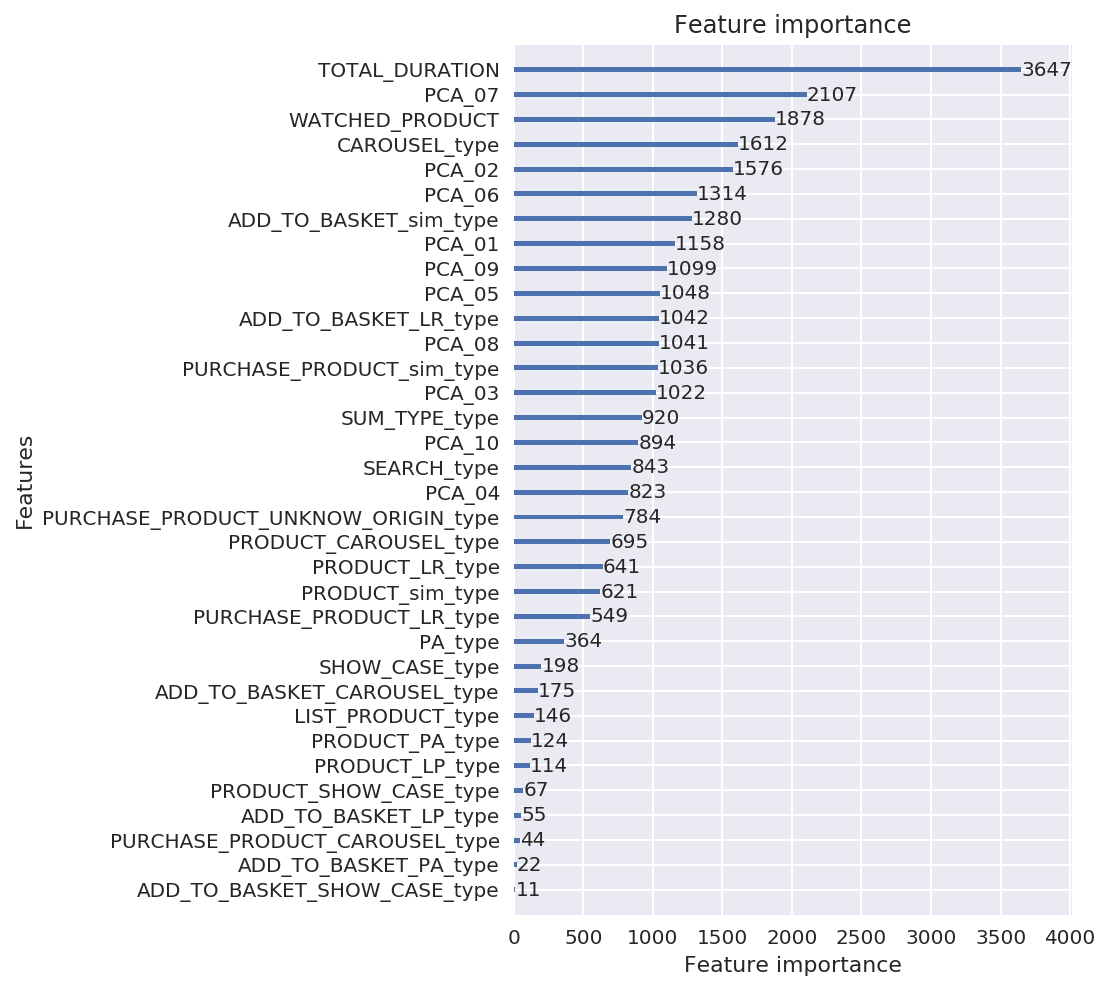

In [295]:
plot_importance(clf, figsize=(5,8))

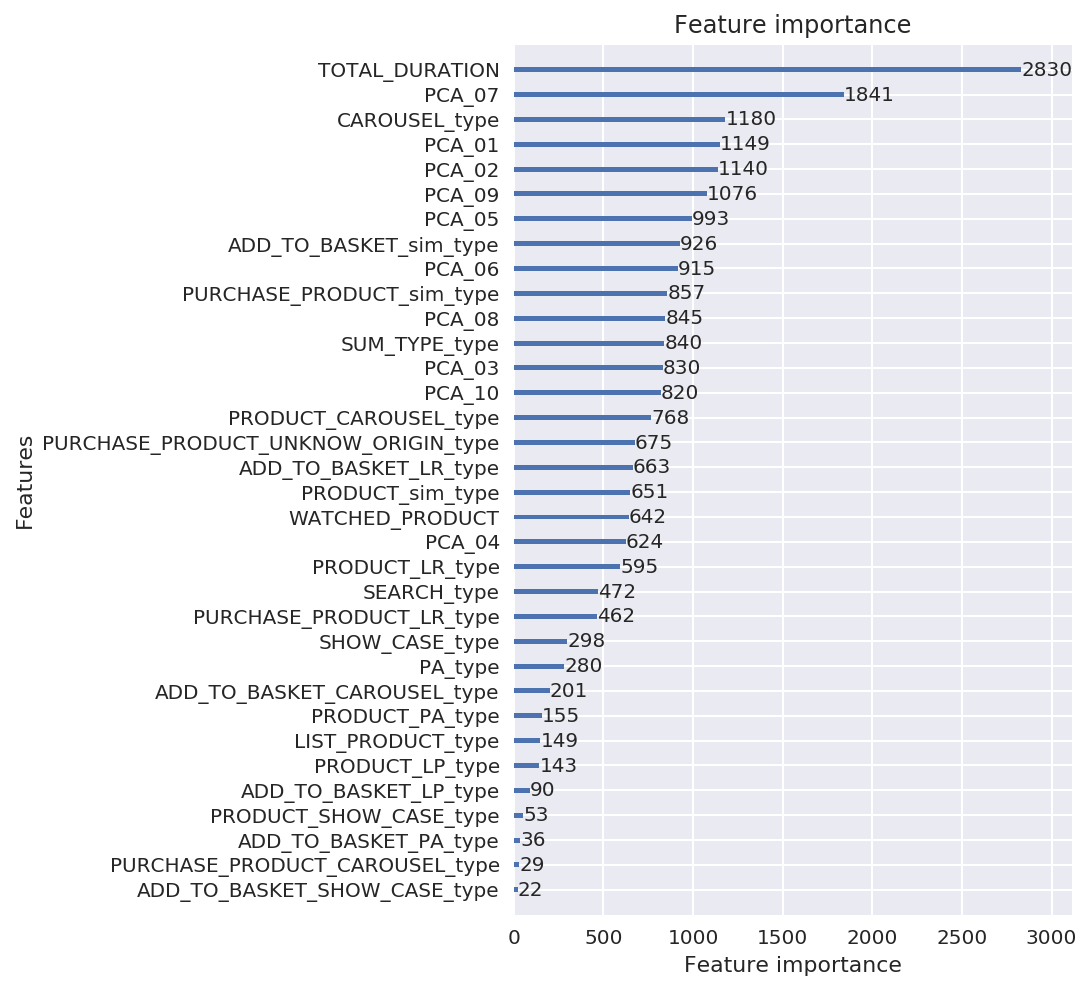

In [291]:
plot_importance(clf, figsize=(5,8))

In [ ]:
import lightgbm as lgbm

# parameters for LightGBMClassifier
params = {
    'objective' :'binary',
    'num_leaves' : 42,
    'boosting_type' : 'dart',
    'xgboost_dart_mode': True,
    'learning_rate': 0.01,
    'metric': 'binary_logloss',
    'verbose': 1,
    'bagging_fraction': 0.5,
}

d_train = lgbm.Dataset(X_train[cont_cols+cat_cols], label=X_train[target_col])
d_valid = lgbm.Dataset(X_val[cont_cols+cat_cols], label=X_val[target_col])

clf = lgbm.train(params, d_train, valid_sets=[d_valid],
                num_boost_round=100000, early_stopping_rounds=30, verbose_eval=100)

In [217]:
X_train['target'] = list(trn_session.target)
X_val['target'] = list(val_session.target)

In [218]:
X_train.head()

,ADD_TO_BASKET_CAROUSEL_type,ADD_TO_BASKET_LP_type,ADD_TO_BASKET_LR_type,ADD_TO_BASKET_PA_type,ADD_TO_BASKET_SHOW_CASE_type,CAROUSEL_type,LIST_PRODUCT_type,PA_type,PRODUCT_CAROUSEL_type,PRODUCT_LP_type,PRODUCT_LR_type,PRODUCT_PA_type,PRODUCT_SHOW_CASE_type,PURCHASE_PRODUCT_CAROUSEL_type,PURCHASE_PRODUCT_LP_type,PURCHASE_PRODUCT_LR_type,PURCHASE_PRODUCT_PA_type,PURCHASE_PRODUCT_SHOW_CASE_type,PURCHASE_PRODUCT_UNKNOW_ORIGIN_type,SEARCH_type,SHOW_CASE_type,SUM_TYPE_type,ADD_TO_BASKET_sim_type,CAROUSEL_sim_type,LIST_PRODUCT_sim_type,PA_sim_type,PRODUCT_sim_type,PURCHASE_PRODUCT_sim_type,SEARCH_sim_type,SHOW_CASE_sim_type,SUM_TYPE_SIMPLIFIED_sim_type,TOTAL_DURATION,PCA_01,PCA_02,PCA_03,PCA_04,PCA_05,PCA_06,PCA_07,PCA_08,PCA_09,PCA_10,WATCHED_PRODUCT,target
0,-0.138145,-0.093051,-0.322523,-0.04508,-0.054139,-0.331188,-0.357793,-0.445112,0.567509,-0.227689,-0.360090,-0.172671,-0.181197,-0.030073,-0.017845,-0.067902,-0.012395,-0.012041,-0.080104,1.111858,-0.431899,0.942648,-0.373516,-0.331188,-0.357793,-0.445112,-0.154530,-0.101517,1.111858,-0.431899,0.942648,0.916403,1.522256,0.760181,0.689531,-0.038946,0.412100,-0.016194,1.215412,-1.019899,0.162570,0.048782,4169,False
1,-0.138145,-0.093051,-0.322523,-0.04508,-0.054139,-0.956766,-0.357793,-0.712659,-0.393631,-0.227689,0.311095,-0.172671,-0.181197,-0.030073,-0.017845,-0.067902,-0.012395,-0.012041,-0.080104,1.789222,-0.431899,-0.153072,-0.373516,-0.956766,-0.357793,-0.712659,-0.154530,-0.101517,1.789222,-0.431899,-0.153072,-0.335600,2.950265,0.004903,0.388526,-0.348097,-0.359296,-0.854168,-0.250241,-0.588898,0.408296,0.015118,23070,False
2,-0.138145,-0.093051,-0.322523,-0.04508,-0.054139,2.171124,-0.357793,-0.712659,-0.393631,-0.227689,-0.695683,-0.172671,-0.181197,-0.030073,-0.017845,-0.067902,-0.012395,-0.012041,-0.080104,-0.513815,-0.431899,-0.290037,-0.373516,2.171124,-0.357793,-0.712659,-1.024832,-0.101517,-0.513815,-0.431899,-0.290037,-0.281668,-1.737104,1.748503,-0.715823,-0.304218,-0.400378,-0.298561,-0.533274,-2.140468,0.521907,0.246609,25500,True
3,-0.138145,-0.093051,2.957465,-0.04508,-0.054139,0.408131,-0.357793,-0.128920,-0.393631,-0.227689,-0.695683,-0.172671,-0.181197,-0.030073,-0.017845,-0.067902,-0.012395,-0.012041,-0.080104,-0.168975,0.131392,0.052376,2.600868,0.408131,-0.357793,-0.128920,-1.024832,-0.101517,-0.168975,0.131392,0.052376,-0.347367,-0.102583,0.823701,-0.275705,1.347930,1.978734,1.708203,-2.636072,-0.235770,-0.116624,-0.221252,23918,False
4,-0.138145,-0.093051,-0.322523,-0.04508,-0.054139,-0.206073,2.922771,-0.712659,-0.393631,3.507967,-0.695683,-0.172671,-0.181197,-0.030073,-0.017845,-0.067902,-0.012395,-0.012041,-0.080104,-1.055706,-0.431899,-0.358519,-0.373516,-0.206073,2.922771,-0.712659,0.367652,-0.101517,-1.055706,-0.431899,-0.358519,-0.355491,-2.221114,-1.816749,3.740868,0.161258,-2.912414,0.422865,-0.847075,0.249206,0.140486,0.236068,20951,False


In [237]:
X_train.reset_index(drop=True).to_feather(PROCESSED/'train_PCA_idProd.feather')
X_val.reset_index(drop=True).to_feather(PROCESSED/'val_PCA_idProd.feather')

In [236]:
for df in [X_train, X_val]:
    df['WATCHED_PRODUCT'] = df.WATCHED_PRODUCT.cat.codes

In [98]:
def apply_cats(df, trn):
    """Changes any columns of strings in df (DataFrame) into categorical variables
    using trn (DataFrame) as a template for the category codes (inplace)."""
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = pd.Categorical(c, categories=trn[n].cat.categories, ordered=True)

def to_cat_codes(df, cat_cols):
    for col in cat_cols:
        df[col] = df[col].astype('category').cat.as_ordered()

In [209]:
for df in [X_train, X_val]:
    df['WATCHED_PRODUCT'] = (df.WATCHED_PRODUCT.fillna(-1) + 1).astype(int).astype('category')

In [210]:
X_train.head()

,ADD_TO_BASKET_CAROUSEL_type,ADD_TO_BASKET_LP_type,ADD_TO_BASKET_LR_type,ADD_TO_BASKET_PA_type,ADD_TO_BASKET_SHOW_CASE_type,CAROUSEL_type,LIST_PRODUCT_type,PA_type,PRODUCT_CAROUSEL_type,PRODUCT_LP_type,PRODUCT_LR_type,PRODUCT_PA_type,PRODUCT_SHOW_CASE_type,PURCHASE_PRODUCT_CAROUSEL_type,PURCHASE_PRODUCT_LP_type,PURCHASE_PRODUCT_LR_type,PURCHASE_PRODUCT_PA_type,PURCHASE_PRODUCT_SHOW_CASE_type,PURCHASE_PRODUCT_UNKNOW_ORIGIN_type,SEARCH_type,SHOW_CASE_type,SUM_TYPE_type,ADD_TO_BASKET_sim_type,CAROUSEL_sim_type,LIST_PRODUCT_sim_type,PA_sim_type,PRODUCT_sim_type,PURCHASE_PRODUCT_sim_type,SEARCH_sim_type,SHOW_CASE_sim_type,SUM_TYPE_SIMPLIFIED_sim_type,TOTAL_DURATION,PCA_01,PCA_02,PCA_03,PCA_04,PCA_05,PCA_06,PCA_07,PCA_08,PCA_09,PCA_10,WATCHED_PRODUCT,target
0,-0.138145,-0.093051,-0.322523,-0.04508,-0.054139,-0.331188,-0.357793,-0.445112,0.567509,-0.227689,-0.360090,-0.172671,-0.181197,-0.030073,-0.017845,-0.067902,-0.012395,-0.012041,-0.080104,1.111858,-0.431899,0.942648,-0.373516,-0.331188,-0.357793,-0.445112,-0.154530,-0.101517,1.111858,-0.431899,0.942648,0.916403,1.522256,0.760181,0.689531,-0.038946,0.412100,-0.016194,1.215412,-1.019899,0.162570,0.048782,4169,NaN
1,-0.138145,-0.093051,-0.322523,-0.04508,-0.054139,-0.956766,-0.357793,-0.712659,-0.393631,-0.227689,0.311095,-0.172671,-0.181197,-0.030073,-0.017845,-0.067902,-0.012395,-0.012041,-0.080104,1.789222,-0.431899,-0.153072,-0.373516,-0.956766,-0.357793,-0.712659,-0.154530,-0.101517,1.789222,-0.431899,-0.153072,-0.335600,2.950265,0.004903,0.388526,-0.348097,-0.359296,-0.854168,-0.250241,-0.588898,0.408296,0.015118,23070,False
2,-0.138145,-0.093051,-0.322523,-0.04508,-0.054139,2.171124,-0.357793,-0.712659,-0.393631,-0.227689,-0.695683,-0.172671,-0.181197,-0.030073,-0.017845,-0.067902,-0.012395,-0.012041,-0.080104,-0.513815,-0.431899,-0.290037,-0.373516,2.171124,-0.357793,-0.712659,-1.024832,-0.101517,-0.513815,-0.431899,-0.290037,-0.281668,-1.737104,1.748503,-0.715823,-0.304218,-0.400378,-0.298561,-0.533274,-2.140468,0.521907,0.246609,25500,False
3,-0.138145,-0.093051,2.957465,-0.04508,-0.054139,0.408131,-0.357793,-0.128920,-0.393631,-0.227689,-0.695683,-0.172671,-0.181197,-0.030073,-0.017845,-0.067902,-0.012395,-0.012041,-0.080104,-0.168975,0.131392,0.052376,2.600868,0.408131,-0.357793,-0.128920,-1.024832,-0.101517,-0.168975,0.131392,0.052376,-0.347367,-0.102583,0.823701,-0.275705,1.347930,1.978734,1.708203,-2.636072,-0.235770,-0.116624,-0.221252,23918,NaN
4,-0.138145,-0.093051,-0.322523,-0.04508,-0.054139,-0.206073,2.922771,-0.712659,-0.393631,3.507967,-0.695683,-0.172671,-0.181197,-0.030073,-0.017845,-0.067902,-0.012395,-0.012041,-0.080104,-1.055706,-0.431899,-0.358519,-0.373516,-0.206073,2.922771,-0.712659,0.367652,-0.101517,-1.055706,-0.431899,-0.358519,-0.355491,-2.221114,-1.816749,3.740868,0.161258,-2.912414,0.422865,-0.847075,0.249206,0.140486,0.236068,20951,NaN


In [248]:
cont_cols = [x for x in X_train if x!='WATCHED_PRODUCT' and x!='sid' and x!='target']
cat_cols = ['WATCHED_PRODUCT']
target_col = 'target'

In [251]:
from src.utils_r import StructuredDataset
trn_ds = StructuredDataset(X_train[cat_cols], X_train[cont_cols], 
                           X_train[target_col])
val_ds = StructuredDataset(X_val[cat_cols], X_val[cont_cols],
                           X_val[target_col])

In [252]:
batch_size = 128

In [253]:
from torch.utils.data import DataLoader
trn_dl = DataLoader(trn_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size)

In [278]:
cat_szs = [int(X_train[col].max() + 1) for col in cat_cols]
emb_szs = [(c, min(10, (c+1)//2)) for c in cat_szs]

In [279]:
emb_szs

[(38508, 10)]

In [280]:
USE_CUDA = True

In [281]:
from src.utils_r import StructuredNet
model = StructuredNet(emb_szs, len(cont_cols), emb_drop=0.3, szs=[250, 50],
                      drops=[0.3, 0.3], out_sz=1)
if USE_CUDA: model = model.cuda()

In [282]:
from torch import optim
import torch.nn as nn
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.BCEWithLogitsLoss()

In [283]:
from src.utils_r import structured_train_model

In [284]:
%%time
best_epoch = structured_train_model(model, trn_dl, val_dl, optimizer, criterion,
                                    n_epochs=10, USE_CUDA=USE_CUDA)

Train Epoch: 1 [12800/79873 (16%)]	Loss: 0.694602
Train Epoch: 1 [25600/79873 (32%)]	Loss: 0.578023
Train Epoch: 1 [38400/79873 (48%)]	Loss: 0.482363
Train Epoch: 1 [51200/79873 (64%)]	Loss: 0.406563
Train Epoch: 1 [64000/79873 (80%)]	Loss: 0.355824
Train Epoch: 1 [76800/79873 (96%)]	Loss: 0.320012
Epoch: 1 | Train Logloss: 0.287614 | Val Logloss: 0.294177
Train Epoch: 2 [12800/79873 (16%)]	Loss: 0.295643
Train Epoch: 2 [25600/79873 (32%)]	Loss: 0.293077
Train Epoch: 2 [38400/79873 (48%)]	Loss: 0.282576
Train Epoch: 2 [51200/79873 (64%)]	Loss: 0.287782
Train Epoch: 2 [64000/79873 (80%)]	Loss: 0.288465
Train Epoch: 2 [76800/79873 (96%)]	Loss: 0.283379
Epoch: 2 | Train Logloss: 0.270503 | Val Logloss: 0.279068
Train Epoch: 3 [12800/79873 (16%)]	Loss: 0.282384
Train Epoch: 3 [25600/79873 (32%)]	Loss: 0.289846
Train Epoch: 3 [38400/79873 (48%)]	Loss: 0.276758
Train Epoch: 3 [51200/79873 (64%)]	Loss: 0.277893
Train Epoch: 3 [64000/79873 (80%)]	Loss: 0.275380
Train Epoch: 3 [76800/79873 (96%

In [125]:
%%time
best_epoch = structured_train_model(model, trn_dl, val_dl, optimizer, criterion,
                                    n_epochs=10, USE_CUDA=USE_CUDA)

Train Epoch: 1 [12800/79873 (16%)]	Loss: 0.693171
Train Epoch: 1 [25600/79873 (32%)]	Loss: 0.532893
Train Epoch: 1 [38400/79873 (48%)]	Loss: 0.416017
Train Epoch: 1 [51200/79873 (64%)]	Loss: 0.338634
Train Epoch: 1 [64000/79873 (80%)]	Loss: 0.307709
Train Epoch: 1 [76800/79873 (96%)]	Loss: 0.295217
Epoch: 1 | Train Logloss: 0.274365 | Val Logloss: 0.282227
Train Epoch: 2 [12800/79873 (16%)]	Loss: 0.292080
Train Epoch: 2 [25600/79873 (32%)]	Loss: 0.278932
Train Epoch: 2 [38400/79873 (48%)]	Loss: 0.285187
Train Epoch: 2 [51200/79873 (64%)]	Loss: 0.278153
Train Epoch: 2 [64000/79873 (80%)]	Loss: 0.283095
Train Epoch: 2 [76800/79873 (96%)]	Loss: 0.281543
Epoch: 2 | Train Logloss: 0.268669 | Val Logloss: 0.277613
Train Epoch: 3 [12800/79873 (16%)]	Loss: 0.273323
Train Epoch: 3 [25600/79873 (32%)]	Loss: 0.284865
Train Epoch: 3 [38400/79873 (48%)]	Loss: 0.280515
Train Epoch: 3 [51200/79873 (64%)]	Loss: 0.278361
Train Epoch: 3 [64000/79873 (80%)]	Loss: 0.267962
Train Epoch: 3 [76800/79873 (96%